In [ ]:
%pip install pydub librosa matplotlib "numpy<2" "tensorflow<2.11.0" "tensorflow-gpu<2.11.0"

In [1]:
import os
from pydub import AudioSegment

# 디렉토리 설정
input_dir = './m4a'
output_dir = './wav'

# 출력 디렉토리 생성
os.makedirs(output_dir, exist_ok=True)

# m4a 파일 리스트
files = [f for f in os.listdir(input_dir) if f.endswith('.m4a')]

slice_index = 1  # noise1.wav부터 시작

for file in files:
    m4a_path = os.path.join(input_dir, file)

    # m4a 파일 로드
    sound = AudioSegment.from_file(m4a_path, format="m4a")

    # 전체 길이를 1초 단위로 자르기
    full_seconds = len(sound) // 1000  # 남는 부분은 버림

    for i in range(full_seconds):
        start = i * 1000
        end = start + 1000
        segment = sound[start:end]

        # 출력 파일 경로: noise1.wav, noise2.wav, ...
        output_filename = f"noise{slice_index}.wav"
        output_path = os.path.join(output_dir, output_filename)

        # 저장
        segment.export(output_path, format="wav")
        slice_index += 1


In [8]:
import numpy as np
import librosa

# RMS 추출 함수
def extract_rms_from_file(file_path, frame_length=2048, hop_length=512):
    y, sr = librosa.load(file_path, sr=None)
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    return rms, sr

# 시퀀스 생성 함수
def create_sequences(data, window_size, stride=5):
    X, y = [], []
    for i in range(0, len(data) - window_size, stride):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

In [9]:
import os
import numpy as np

# 경로 및 파라미터 설정
wav_dir = './wav'
window_size = 20

# 전체 데이터 수집
X_all, y_all = [], []

for filename in os.listdir(wav_dir):
    if filename.endswith('.wav'):
        file_path = os.path.join(wav_dir, filename)
        rms, sr = extract_rms_from_file(file_path)
        X, y = create_sequences(rms, window_size)
        X_all.append(X)
        y_all.append(y)

# 하나의 큰 배열로 합치기
X_total = np.concatenate(X_all, axis=0)
y_total = np.concatenate(y_all, axis=0)

# LSTM 입력 형식으로 변형
X_total = X_total.reshape((X_total.shape[0], X_total.shape[1], 1))

print(f'총 시퀀스 개수: {X_total.shape[0]}, 입력 shape: {X_total.shape}')
print(f'총 레이블 개수: {y_total.shape[0]}, 레이블 shape: {y_total.shape}')

총 시퀀스 개수: 39282, 입력 shape: (39282, 20, 1)
총 레이블 개수: 39282, 레이블 shape: (39282,)


In [11]:
print(X_total[0].flatten()) # 첫 번째 시퀀스 출력
print(y_total[0]) # 첫 번째 레이블 출력

[0.         0.00095597 0.04456605 0.06113401 0.07354543 0.08515146
 0.08317228 0.08389068 0.08674265 0.08750504 0.0908769  0.09072655
 0.08754595 0.08558008 0.08159105 0.0783785  0.07564511 0.0737889
 0.07197184 0.07130171]
0.07169764


Epoch 1/50
983/983 [==============================] - 8s 6ms/step - loss: 1.7965e-04 - val_loss: 4.3016e-05
Epoch 2/50
983/983 [==============================] - 7s 7ms/step - loss: 5.9222e-05 - val_loss: 3.1019e-05
Epoch 3/50
983/983 [==============================] - 6s 6ms/step - loss: 5.4307e-05 - val_loss: 3.0090e-05
Epoch 4/50
983/983 [==============================] - 6s 6ms/step - loss: 5.4385e-05 - val_loss: 3.7594e-05
Epoch 5/50
983/983 [==============================] - 6s 6ms/step - loss: 5.3683e-05 - val_loss: 3.2927e-05
Epoch 6/50
983/983 [==============================] - 6s 6ms/step - loss: 5.2340e-05 - val_loss: 3.9966e-05
Epoch 7/50
983/983 [==============================] - 5s 6ms/step - loss: 5.1302e-05 - val_loss: 2.8892e-05
Epoch 8/50
983/983 [==============================] - 5s 5ms/step - loss: 4.5980e-05 - val_loss: 2.8476e-05
Epoch 9/50
983/983 [==============================] - 5s 5ms/step - loss: 4.4629e-05 - val_loss: 2.6242e-05
Epoch 10/50
983/983 [=======

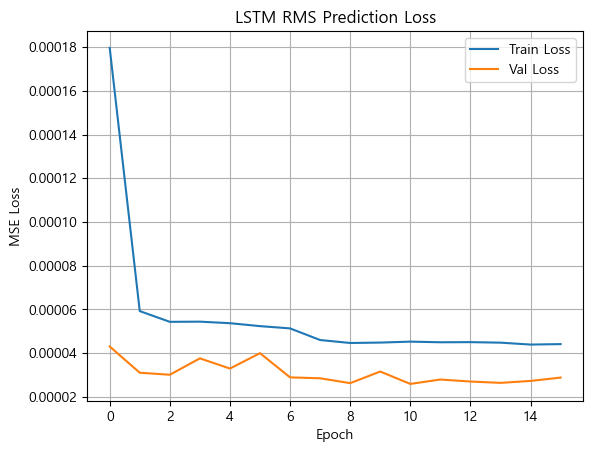

In [12]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
import matplotlib.pyplot as plt

# LSTM 모델 정의
model = Sequential([
    LSTM(64, input_shape=(X_total.shape[1], 1)),
    Dense(1)  # 다음 시점의 RMS 값을 예측
])

model.compile(optimizer='adam', loss='mse')

# 조기 종료 콜백
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(
    X_total, y_total,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

# 모델 저장
model.save('lstm_rms_model.h5')

# 학습 손실 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM RMS Prediction Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
from tensorflow.keras.models import load_model  # type: ignore

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 디렉토리 설정
wav_dir = './wav'
prediction_dir = './prediction'
os.makedirs(prediction_dir, exist_ok=True)

# 하이퍼파라미터
window_size = 20
stride = 10
frame_length = 2048
hop_length = 512

# 모델 불러오기
model = load_model('lstm_rms_model.h5')

# 예측 및 시각화
for filename in os.listdir(wav_dir):
    if filename.endswith('.wav'):
        file_path = os.path.join(wav_dir, filename)
        rms, sr = extract_rms_from_file(file_path, frame_length, hop_length)

        # 시간 벡터 생성
        frames = np.arange(len(rms))
        times = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)

        # 시퀀스 생성
        X, y_true = create_sequences(rms, window_size, stride=stride)
        X = X.reshape((X.shape[0], X.shape[1], 1))

        # 예측
        y_pred = model.predict(X).flatten()

        # 예측용 x축 (시간 단위)
        pred_times = times[window_size::stride][:len(y_pred)]

        # 시각화
        plt.figure(figsize=(10, 6))
        plt.plot(times, rms, label='Original RMS')
        plt.plot(pred_times, y_pred, label='Predicted RMS', color='orange')
        plt.title(f'{filename} - RMS Prediction')
        plt.xlabel('Time (s)')
        plt.ylabel('RMS')
        plt.legend()
        plt.grid(True)

        # 저장
        prediction_file_path = os.path.join(prediction_dir, f'{os.path.splitext(filename)[0]}_prediction.png')
        plt.savefig(prediction_file_path)
        plt.close()


In [15]:
import numpy as np
import librosa

# 특징 추출 함수
def extract_features_from_file(file_path):
    y, sr = librosa.load(file_path, sr=None)
    rms = librosa.feature.rms(y=y)[0]
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
    zero_crossing = librosa.feature.zero_crossing_rate(y)[0]

    # 최소 길이 맞춤
    min_len = min(len(rms), len(centroid), len(bandwidth), len(zero_crossing))
    features = np.vstack([
        rms[:min_len],
        centroid[:min_len],
        bandwidth[:min_len],
        zero_crossing[:min_len]
    ]).T

    return features, sr

# 시퀀스 생성 함수 (다변량)
def create_multivariate_sequences(data, window_size, stride=5):
    X, y = [], []
    for i in range(0, len(data) - window_size, stride):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])  # 다음 시점의 전체 feature 예측
    return np.array(X), np.array(y)

In [16]:
import os
import numpy as np

wav_dir = './wav'
window_size = 20
stride = 10

X_total, y_total = [], []

for filename in os.listdir(wav_dir):
    if filename.endswith('.wav'):
        path = os.path.join(wav_dir, filename)
        features, _ = extract_features_from_file(path)
        X_seq, y_seq = create_multivariate_sequences(features, window_size, stride=stride)
        X_total.append(X_seq)
        y_total.append(y_seq)

X_total = np.vstack(X_total)
y_total = np.vstack(y_total)

print(f'총 시퀀스 개수: {X_total.shape[0]}, 입력 shape: {X_total.shape}')
print(f'총 레이블 개수: {y_total.shape[0]}, 레이블 shape: {y_total.shape}')

총 시퀀스 개수: 20060, 입력 shape: (20060, 20, 4)
총 레이블 개수: 20060, 레이블 shape: (20060, 4)


Epoch 1/50
502/502 [==============================] - 9s 11ms/step - loss: 0.0047 - val_loss: 0.0028
Epoch 2/50
502/502 [==============================] - 5s 11ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 3/50
502/502 [==============================] - 6s 11ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 4/50
502/502 [==============================] - 5s 10ms/step - loss: 8.4027e-04 - val_loss: 9.0548e-04
Epoch 5/50
502/502 [==============================] - 5s 9ms/step - loss: 7.3991e-04 - val_loss: 8.7219e-04
Epoch 6/50
502/502 [==============================] - 5s 10ms/step - loss: 6.9934e-04 - val_loss: 8.0909e-04
Epoch 7/50
502/502 [==============================] - 5s 11ms/step - loss: 6.8361e-04 - val_loss: 8.1217e-04
Epoch 8/50
502/502 [==============================] - 5s 10ms/step - loss: 6.6689e-04 - val_loss: 8.7086e-04
Epoch 9/50
502/502 [==============================] - 5s 9ms/step - loss: 6.5032e-04 - val_loss: 7.7958e-04
Epoch 10/50
502/502 [========================

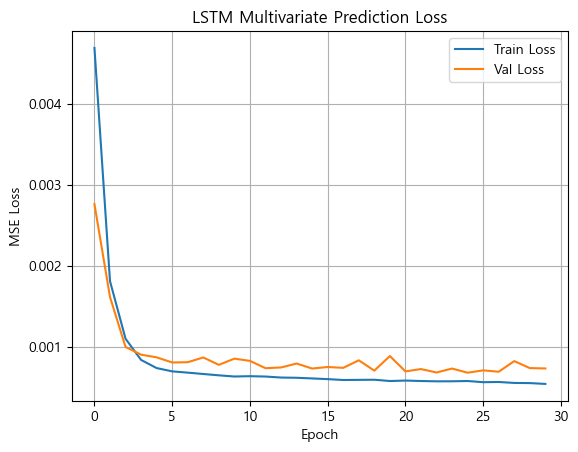

In [17]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from joblib import dump

scaler = MinMaxScaler()
X_total_scaled = scaler.fit_transform(X_total.reshape(-1, X_total.shape[-1])).reshape(X_total.shape)
y_total_scaled = scaler.fit_transform(y_total)
dump(scaler, 'scaler_y.joblib')

# LSTM 모델 정의
model = Sequential([
    LSTM(64, input_shape=(window_size, 4), return_sequences=True),
    TimeDistributed(Dense(64)),  # 시계열 각 시점별로 Dense(32) 적용
    LSTM(32),
    Dense(16),
    Dense(4)  # 다음 시점의 모든 feature 예측: [RMS, 중심주파수, 주파수폭, 제로크로싱]
])

model.compile(optimizer='adam', loss='mse')

# 조기 종료 콜백
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(
    X_total_scaled, y_total_scaled,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

# 모델 저장
model.save('lstm_all_feature_predictor.h5')

# 손실 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Multivariate Prediction Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from tensorflow.keras.models import load_model # type: ignore
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
from joblib import load

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

feature_dir = './feature_prediction'
os.makedirs(feature_dir, exist_ok=True)

stride=10
hop_length=512

# 모델 로드
model = load_model('lstm_all_feature_predictor.h5')
scaler = load('scaler_y.joblib')

# 예측 및 시각화
for filename in os.listdir(wav_dir):
    if filename.endswith('.wav'):
        path = os.path.join(wav_dir, filename)
        features, sr = extract_features_from_file(path)
        X, y_true = create_multivariate_sequences(features, window_size, stride=stride)
        X_scaled = scaler.transform(X.reshape(-1, 4)).reshape(X.shape)

        y_pred_scaled = model.predict(X_scaled)
        y_pred = scaler.inverse_transform(y_pred_scaled)  # 역정규화

        # 시간축
        frames = np.arange(len(features))
        times = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)
        pred_times = times[window_size::stride][:len(y_pred)]

        # 시각화
        feature_names = ['RMS', 'Centroid', 'Bandwidth', 'ZCR']
        for i in range(4):
            plt.figure(figsize=(10, 4))
            plt.plot(times, features[:, i], label=f'Original {feature_names[i]}')
            plt.plot(pred_times, y_pred[:, i], label=f'Predicted {feature_names[i]}', color='orange')
            plt.title(f'{filename} - {feature_names[i]} Prediction')
            plt.xlabel('Time (s)')
            plt.ylabel(feature_names[i])
            plt.legend()
            plt.grid(True)

            save_path = os.path.join(feature_dir, f"{os.path.splitext(filename)[0]}_{feature_names[i]}.png")
            plt.savefig(save_path)
            plt.close()

In [1]:
#  1. 라이브러리 임포트
import os
import numpy as np
import librosa
import joblib
from sklearn.model_selection import train_test_split 
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # type: ignore
from sklearn.preprocessing import MinMaxScaler

#  2. 상수 설정
SAMPLE_RATE = 16000
FRAME_DURATION = 0.05
FRAME_SIZE = int(SAMPLE_RATE * FRAME_DURATION)
SEQUENCE_LENGTH = 5
P0 = 20e-6  # 기준압력 (20 µPa)

#  3. 주파수 및 위상 추정 함수
def estimate_frequency(signal, sr):
    fft = np.fft.rfft(signal)
    magnitude = np.abs(fft)
    freqs = np.fft.rfftfreq(len(signal), 1/sr)
    peak_idx = np.argmax(magnitude)
    return freqs[peak_idx]

def estimate_phase(signal, freq, sr):
    t = np.arange(len(signal)) / sr
    phase_shift = np.angle(np.sum(signal * np.exp(-1j * 2 * np.pi * freq * t)))
    return phase_shift

#  4. 특징 추출 함수: freq, amp(FFT peak amplitude 기반 dB), phase
def amplitude_to_db(amp, p0=P0, min_db=-80):
    amp = np.maximum(amp, 1e-20)  # 로그 0 방지
    db = 20 * np.log10(amp / p0)
    db = np.maximum(db, min_db)
    return db

def extract_features(signal):
    fft = np.fft.rfft(signal)
    magnitude = np.abs(fft)
    freqs = np.fft.rfftfreq(len(signal), 1/SAMPLE_RATE)

    peak_idx = np.argmax(magnitude)
    freq = freqs[peak_idx]
    peak_amp = magnitude[peak_idx]

    amp_db = amplitude_to_db(peak_amp)
    phase = np.angle(fft[peak_idx])

    return np.array([freq, amp_db, phase], dtype=np.float32)


In [16]:
# 📌 5. 전체 wav 폴더에서 데이터셋 로딩
def load_dataset(folder_path):
    X_all, y_all = [], []
    for filename in os.listdir(folder_path):
        if filename.endswith(".wav"):
            filepath = os.path.join(folder_path, filename)
            signal, _ = librosa.load(filepath, sr=SAMPLE_RATE)

            features = []
            for i in range(0, len(signal) - FRAME_SIZE, FRAME_SIZE):
                frame = signal[i:i + FRAME_SIZE]
                feature = extract_features(frame)
                features.append(feature)

            features = np.array(features)

            # 예측할 길이 설정 (미래 10프레임)
            PREDICT_LENGTH = 1

            for i in range(len(features) - SEQUENCE_LENGTH - PREDICT_LENGTH):
                X_seq = features[i:i + SEQUENCE_LENGTH]  # (SEQUENCE_LENGTH, 3)
                y_seq = features[i + SEQUENCE_LENGTH:i + SEQUENCE_LENGTH + PREDICT_LENGTH]  # (1, 3)
                y_flat = y_seq.flatten()  # (1 * 3 = 30,)

                X_all.append(X_seq)
                y_all.append(y_flat)

    return np.array(X_all), np.array(y_all)

In [3]:
X, y = load_dataset('./wav')
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (738900, 5, 3)
y shape: (738900, 30)


In [18]:
# 📌 6. 데이터 로딩 및 분할
X, y = load_dataset('./wav')  # 학습용 wav 폴더 경로
print(f"전체 샘플 수: {len(X)}")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

num_samples, time_steps, num_features = X_train.shape

# 타겟 정규화 (예: 주파수, 진폭, 위상)
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train)
y_val_scaled = target_scaler.transform(y_val)

X_train_2d = X_train.reshape(num_samples, time_steps * num_features)
scaler_x = MinMaxScaler().fit(X_train_2d)
scaler_y = MinMaxScaler().fit(y_train)   # shape=(?, 3)

joblib.dump(scaler_x, 'scaler_lstm_x.joblib')
joblib.dump(scaler_y, 'scaler_lstm_y.joblib')

# EarlyStopping: val_loss가 5 epoch 이상 개선되지 않으면 종료
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

# ModelCheckpoint: 가장 좋은 val_loss 모델 저장
model_checkpoint = ModelCheckpoint(
    'best_model.h5', monitor='val_loss', save_best_only=True, verbose=1
)

# 📌 7. 모델 정의
model = Sequential([
    LSTM(64, input_shape=(SEQUENCE_LENGTH, 3), return_sequences=True),
    LSTM(64),
    Dense(128, activation='relu'),
    Dense(3)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


# 학습 시 scaled된 y 사용
model.fit(
    X_train, y_train_scaled,
    validation_data=(X_val, y_val_scaled),
    epochs=5,
    callbacks=[early_stopping, model_checkpoint]
)

전체 샘플 수: 1662400
Epoch 1/5
46752/46755 [============================>.] - ETA: 0s - loss: 7.8829e-04 - mae: 0.0139
Epoch 1: val_loss improved from inf to 0.00075, saving model to best_model.h5
46755/46755 [==============================] - 323s 7ms/step - loss: 7.8830e-04 - mae: 0.0139 - val_loss: 7.4929e-04 - val_mae: 0.0134
Epoch 2/5
46751/46755 [============================>.] - ETA: 0s - loss: 7.5136e-04 - mae: 0.0133
Epoch 2: val_loss improved from 0.00075 to 0.00075, saving model to best_model.h5
46755/46755 [==============================] - 353s 8ms/step - loss: 7.5140e-04 - mae: 0.0133 - val_loss: 7.4924e-04 - val_mae: 0.0135
Epoch 3/5
46754/46755 [============================>.] - ETA: 0s - loss: 7.4090e-04 - mae: 0.0132
Epoch 3: val_loss improved from 0.00075 to 0.00073, saving model to best_model.h5
46755/46755 [==============================] - 301s 6ms/step - loss: 7.4089e-04 - mae: 0.0132 - val_loss: 7.3497e-04 - val_mae: 0.0132
Epoch 4/5
46752/46755 [===================

🎧 실시간 노이즈 캔슬링 시작 (Ctrl+C로 종료)
1/1 [==============================] - 1s 775ms/step
[예측] 주파수: 0.0Hz | 진폭: 0.5321 | 위상: -26.52rad


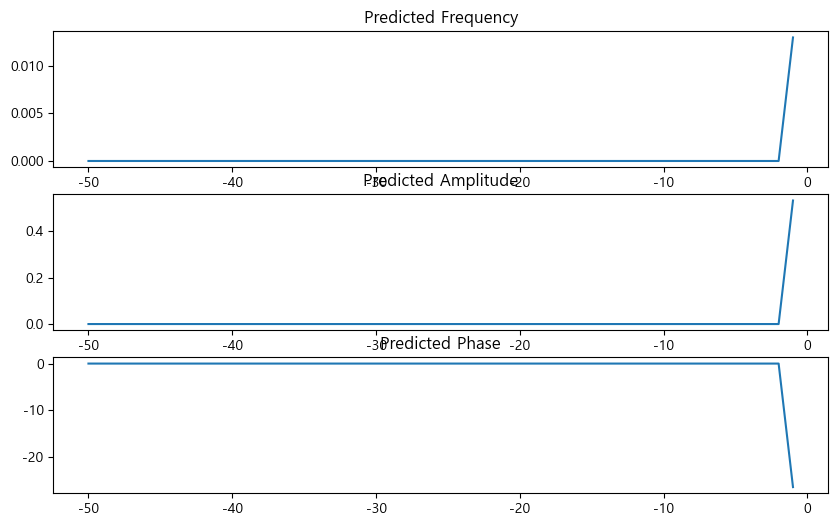

Exception ignored from cffi callback <function _StreamBase.__init__.<locals>.callback_ptr at 0x00000166946C0D30>:
Traceback (most recent call last):
  File "c:\Users\owner\AppData\Local\Programs\Python\Python310\lib\site-packages\sounddevice.py", line 897, in callback_ptr
    return _wrap_callback(
  File "c:\Users\owner\AppData\Local\Programs\Python\Python310\lib\site-packages\sounddevice.py", line 2743, in _wrap_callback
    callback(*args)
  File "C:\Users\owner\AppData\Local\Temp\ipykernel_25100\3953114804.py", line 86, in audio_callback
ValueError: operands could not be broadcast together with shapes (1024,) (512,) 


🛑 스트리밍 종료


In [21]:
import sounddevice as sd
import numpy as np
import librosa
from tensorflow.keras.models import load_model # type: ignore
import joblib
from collections import deque
import matplotlib.pyplot as plt

# === 모델 및 스케일러 로드 ===
model = load_model('best_model.h5')
scaler_x = joblib.load('scaler_lstm_x.joblib')
scaler_y = joblib.load('scaler_lstm_y.joblib')

# === 파라미터 설정 ===
sample_rate = 16000
frame_size = 1024
hop_size = 512
seq_length = 5  # 과거 5프레임 사용

# === 시각화 초기화 ===
plt.ion()
fig, axs = plt.subplots(3, 1, figsize=(10, 6))
axs[0].set_title("Predicted Frequency")
axs[1].set_title("Predicted Amplitude")
axs[2].set_title("Predicted Phase")
x_vals = list(range(-50, 0))
freq_vals, amp_vals, phase_vals = [deque([0]*50, maxlen=50) for _ in range(3)]

# === 특성 시퀀스 저장 버퍼 ===
feature_buffer = deque(maxlen=seq_length)

# === 반대파 생성 함수 ===
def generate_anti_wave(freq, amp, phase, length, sample_rate):
    amp = np.clip(amp, 0.0, 0.1)
    t = np.arange(length) / sample_rate
    wave = amp * np.sin(2 * np.pi * freq * t + phase + np.pi)
    return wave.astype(np.float32)

# === 시각화 업데이트 함수 ===
def update_plot(freq, amp, phase):
    freq_vals.append(freq)
    amp_vals.append(amp)
    phase_vals.append(phase)
    axs[0].cla(); axs[0].set_title("Predicted Frequency")
    axs[1].cla(); axs[1].set_title("Predicted Amplitude")
    axs[2].cla(); axs[2].set_title("Predicted Phase")
    axs[0].plot(x_vals, freq_vals)
    axs[1].plot(x_vals, amp_vals)
    axs[2].plot(x_vals, phase_vals)
    plt.pause(0.01)

# === 오디오 콜백 ===
def audio_callback(indata, outdata, frames, time, status):
    if status:
        print(status)

    mono = indata[:, 0]
    if len(mono) < frame_size:
        mono = np.pad(mono, (0, frame_size - len(mono)), mode='constant')

    rms = librosa.feature.rms(y=mono, frame_length=frame_size, hop_length=hop_size)[0][-1]
    zcr = librosa.feature.zero_crossing_rate(y=mono, frame_length=frame_size, hop_length=hop_size)[0][-1]
    mfcc = librosa.feature.mfcc(y=mono, sr=sample_rate, n_mfcc=13, n_fft=frame_size, hop_length=hop_size)[0, -1]

    feature = np.array([rms, zcr, mfcc])
    feature_buffer.append(feature)

    if len(feature_buffer) < seq_length:
        outdata[:] = np.zeros((frames, 1), dtype=np.float32)
        return

    sequence = np.array(feature_buffer)  # (5, 3)
    sequence_2d = sequence.reshape(1, -1)  # (1, 15)

    sequence_scaled = scaler_x.transform(sequence_2d)
    sequence_scaled_3d = sequence_scaled.reshape(1, seq_length, 3)  # (1, 5, 3)

    prediction_scaled = model.predict(sequence_scaled_3d)
    prediction = scaler_y.inverse_transform(prediction_scaled)

    freq, amp, phase = prediction[0]
    print(f"[예측] 주파수: {freq:.1f}Hz | 진폭: {amp:.4f} | 위상: {phase:.2f}rad")
    update_plot(freq, amp, phase)

    anti_wave = generate_anti_wave(freq, amp, phase, frames, sample_rate)
    mixed_wave = mono + anti_wave
    mixed_wave = np.clip(mixed_wave, -1.0, 1.0)

    outdata[:] = mixed_wave.reshape(-1, 1)

# === 스트림 실행 ===
with sd.Stream(callback=audio_callback, channels=1, samplerate=sample_rate, blocksize=hop_size):
    print("🎧 실시간 노이즈 캔슬링 시작 (Ctrl+C로 종료)")
    try:
        while True:
            sd.sleep(100)
    except KeyboardInterrupt:
        print("🛑 스트리밍 종료")
        plt.ioff()
        plt.show()


FxLMS Noise Cancelling started. Press Ctrl+C to stop and show graphs.
Microphone signal RMS (d): 0.00035
Microphone signal RMS (d): 0.00118
Microphone signal RMS (d): 0.00028
Microphone signal RMS (d): 0.31593
Microphone signal RMS (d): 0.31018
Microphone signal RMS (d): 0.22828

Stopping and plotting graphs...


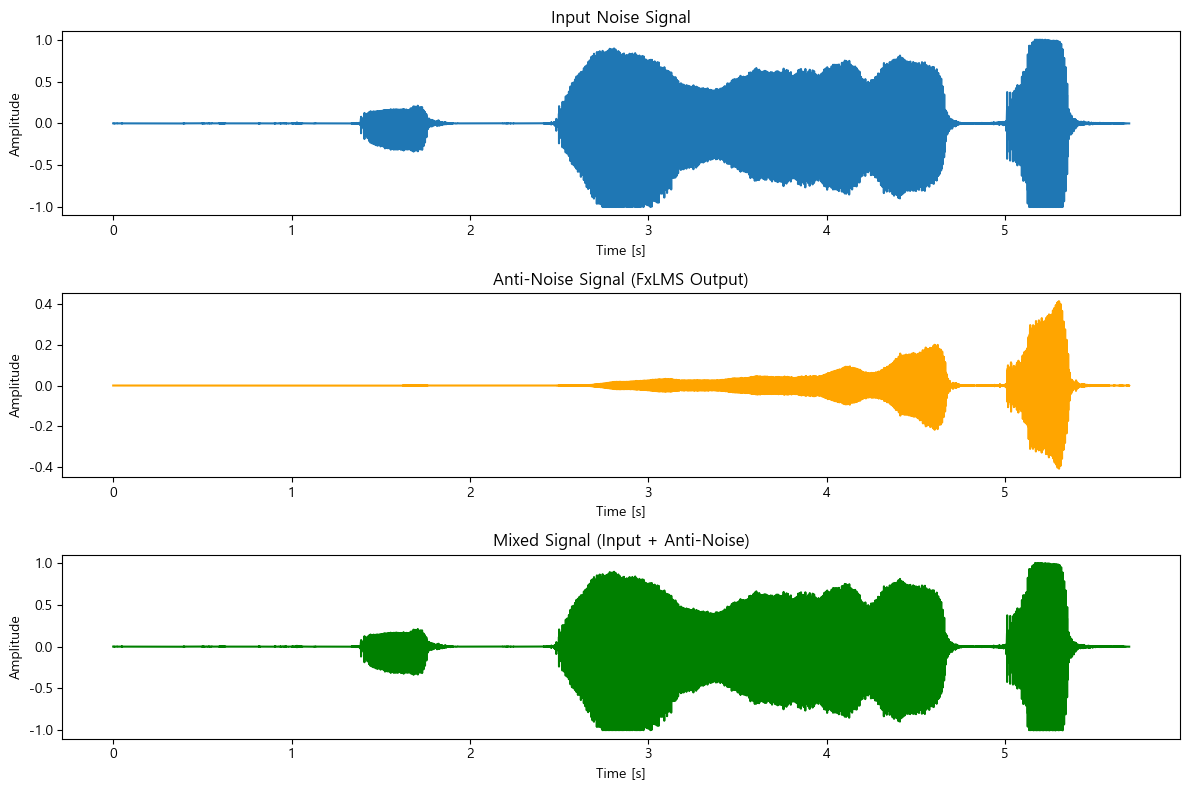

In [61]:
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
from scipy.signal import lfilter
import time

fs = 16000
frame_size = 512
filter_len = 96

mu = 0.003      # FxLMS 학습률 (증가)
mu_sp = 0.00001

# secondary path 초기값을 더 작게 잡음
w_sp = np.random.normal(0, 1e-4, filter_len)
w = np.zeros(filter_len)

x_buffer = np.zeros(filter_len)
x_sp_buffer = np.zeros(filter_len)
anti_buffer = np.zeros(filter_len - 1)

input_history = []
anti_history = []
mixed_history = []

last_print_time = 0

def fx_lms_filter(x, d, w, mu, secondary_path_est, x_buffer):
    N = len(x)
    y = np.zeros(N)
    e = np.zeros(N)

    x_total = np.concatenate((x_buffer, x))
    x_filtered = lfilter(secondary_path_est, [1.0], x_total)

    for n in range(N):
        start_idx = n
        end_idx = n + filter_len
        if end_idx > len(x_total):
            break
        x_n = x_total[start_idx:end_idx][::-1]
        y[n] = np.dot(w, x_n)
        e[n] = d[n] - y[n]

        x_filt_n = x_filtered[start_idx:end_idx][::-1]
        w += 2 * mu * e[n] * x_filt_n

    x_buffer = x_total[-(filter_len-1):]

    return y, e, w, x_buffer

def secondary_path_identification(anti_buffer, d, w_sp, mu_sp, x_sp_buffer):
    N = len(d)
    y_sp = np.zeros(N)
    e_sp = np.zeros(N)

    x_total = np.concatenate((x_sp_buffer, anti_buffer))
    for n in range(N):
        start_idx = n
        end_idx = n + filter_len
        if end_idx > len(x_total):
            break
        x_n = x_total[start_idx:end_idx][::-1]
        y_sp[n] = np.dot(w_sp, x_n)
        e_sp[n] = d[n] - y_sp[n]
        w_sp += 2 * mu_sp * e_sp[n] * x_n

    x_sp_buffer = x_total[-(filter_len-1):]

    return w_sp, x_sp_buffer

def audio_callback(indata, outdata, frames, time_info, status):
    global w, w_sp, x_buffer, anti_buffer, x_sp_buffer, last_print_time

    if status:
        print(status)

    x = indata[:, 0]

    anti_total = np.concatenate((anti_buffer, np.zeros_like(x)))
    anti_filtered = lfilter(w_sp, [1.0], anti_total)

    d = x + anti_filtered[:len(x)]

    # secondary path 식별용 필터 업데이트
    w_sp, x_sp_buffer = secondary_path_identification(anti_buffer, d, w_sp, mu_sp, x_sp_buffer)

    y, e, w, x_buffer = fx_lms_filter(x, d, w, mu, w_sp, x_buffer)
    anti_noise = -y * 2.5  # 출력 gain 증대
    anti_buffer = np.concatenate((anti_buffer, anti_noise))[-(filter_len-1):]

    outdata[:, 0] = anti_noise

    input_history.append(x.copy())
    anti_history.append(anti_noise.copy())
    mixed_history.append(d.copy())

    current_time = time.time()
    if current_time - last_print_time > 1.0:
        rms_d = np.sqrt(np.mean(d**2))
        print(f"Microphone signal RMS (d): {rms_d:.5f}")
        last_print_time = current_time

try:
    with sd.Stream(channels=1, callback=audio_callback,
                   blocksize=frame_size, samplerate=fs):
        print("FxLMS Noise Cancelling started. Press Ctrl+C to stop and show graphs.")
        while True:
            sd.sleep(100)
except KeyboardInterrupt:
    print("\nStopping and plotting graphs...")

    input_all = np.concatenate(input_history)
    anti_all = np.concatenate(anti_history)
    mixed_all = np.concatenate(mixed_history)

    t_all = np.arange(len(input_all)) / fs

    plt.figure(figsize=(12, 8))
    plt.subplot(3,1,1)
    plt.plot(t_all, input_all)
    plt.title("Input Noise Signal")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")

    plt.subplot(3,1,2)
    plt.plot(t_all, anti_all, color='orange')
    plt.title("Anti-Noise Signal (FxLMS Output)")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")

    plt.subplot(3,1,3)
    plt.plot(t_all, mixed_all, color='green')
    plt.title("Mixed Signal (Input + Anti-Noise)")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")

    plt.tight_layout()
    plt.show()
